In [3073]:
import numpy as np
import pandas as pd
import random
import seaborn as sns

In [3074]:
from itertools import combinations, product
from functools import reduce
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from scipy.stats import chi2_contingency, shapiro, probplot, mannwhitneyu
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFECV
from tqdm import tqdm, trange
%matplotlib inline

In [3075]:
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [3076]:
SAMPLE = 7500

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def balance_df_by_target(df, target_name, pr):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.idxmax()
    minor_class_name = target_counts.idxmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1 

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(int(target_counts[minor_class_name] * pr))
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def show_size_matching(df, col):
    plt.figure(figsize=(10, 8))

    sns.countplot(x=col, hue=TARGET_NAME, data=df)
    plt.title(f'{col} grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

def show_chi2_p_vals(df, col):
    vals = list(df.loc[~df[col].isna(), col].unique())
    res = pd.DataFrame(index=sorted(vals), columns=sorted(vals))
    for v1, v2 in product(vals, vals):
        main_value_and_target_s = df.loc[df[col].isin([v1, v2]), ['Id', col, TARGET_NAME]]
        main_value_table = main_value_and_target_s.pivot_table(values='Id', index=col, columns=TARGET_NAME, aggfunc='count')
        _, p, _, _ = chi2_contingency(main_value_table, correction=False)
        res.loc[v1, v2] = round(p, 4)
    print(res)

def get_target_ranges(df, col, func=False):
    col_with_target_s = df[[col, TARGET_NAME]]
    col_s = col_with_target_s[col]
    col_target_0 = col_s[col_with_target_s[TARGET_NAME] == 0]
    col_target_1 = col_s[col_with_target_s[TARGET_NAME] == 1]
    if func:
        col_target_0 = func(col_target_0)
        col_target_1 = func(col_target_1)
    return col_s, col_target_0, col_target_1
    
def show_plot_matching(df, col, func=False):
    col_s, col_target_0, col_target_1 = get_target_ranges(df, col, func)
    plt.figure(figsize=(10, 5))

    sns.kdeplot(col_target_0, shade=True, label='No default', color='g')
    sns.kdeplot(col_target_1, shade=True, label='Default', color='r')

    plt.xlabel(col)
    plt.title(f'{col} grouped by target variable')
    plt.show()

def show_shapiro(df, col):
    col_s, _, _ = get_target_ranges(df, col)
    return shapiro(col_s)

def show_normal_matching(df, col):
    col_s, _, _ = get_target_ranges(df, col)
    plt.figure(figsize=(20, 8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(col)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{col} distribution')
    col_s.hist()

    plt.subplot(122)
    probplot(col_s, dist='norm', plot=plt)
    plt.show()

def show_confidence_int(df, col):
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=TARGET_NAME, y=col, data=df[[col, TARGET_NAME]], capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {col}')
    plt.show()

def show_mannwhitneyu(df, col):
    _, col_target_0, col_target_1 = get_target_ranges(df, col)
    return mannwhitneyu(col_target_0, col_target_1)

In [3077]:
def mod_Home_Ownership(df, col='Home Ownership'):
    df.loc[df[col].isin(['Own Home']), col] = '1'
    df.loc[df[col].isin(['Rent']), col] = '2'
    df.loc[df[col].isin(['Home Mortgage']), col] = '3'
    df.loc[df[col].isin(['Have Mortgage']), col] = '3'
    return df

def mod_Tax_Liens(df, col='Tax Liens'):
    df.loc[df[col].isin([0, 1]), col] = 0
    df.loc[df[col] >= 2, col] = 1
    df[col] = df[col].astype('int8')
    return df

def mod_Term(df, col='Term'):
    df[col] = df[col].map({'Short Term': '0', 'Long Term': '1'}).astype('int8')
    return df

def mod_Purpose(df, col='Purpose'):
    df.loc[df[col].isin(['take a trip', 'debt consolidation', 'wedding', 
                         'buy house', 'vacation']), col] = 'debt consolidation'
    df.loc[df[col].isin(['major purchase', 'buy a car', 'home improvements', 'moving', 'educational expenses']), col] = 'buy a car '
#     df.loc[df[col].isin(['medical bills', 'other']), col] = 'other'
#     df.loc[df[col].isin(['business loan', 'small business']), col] = 'bisness'
    
    uniq = list(df[col].unique())
    for name, i in zip(uniq, range(0, len(uniq))):
        df.loc[df[col] == name, col] = f'{i}'
    df[col] = df[col].astype('str')
    
    return df

def mod_Current_Loan_Amount(df, median, p, col='Current Loan Amount'):
    df.loc[df[col] == 99999999.0, col] = 0
    df = mod_remove_tail(df, col, p)
    df[col] = np.log1p(df[col])
    return df

def mod_Number_of_Credit_Problems(df, col='Number of Credit Problems'):
    df.loc[df[col].isin([0, 1]), col] = 0
    df.loc[df[col].isin([2, 3]), col] = 3
    df.loc[df[col] > 3, col] = 4
    df[col] = df[col].astype('int')
    return df

def mod_Credit_Score(df, median, col='Credit Score'):
    df[col] = df[col].fillna(median)
    return df

def mod_Annual_Income(df, median, p, col='Annual Income'):
    df[col] = df[col].fillna(median)
#     df_clear = df.loc[~(df[col].isna()) & (df['Monthly Debt'] > 100), [col, 'Monthly Debt']]
#     mean_dept_coeff = (df_clear[col] / 12 / df_clear['Monthly Debt']).mean()
#     df.loc[df[col].isna(), col] = df['Monthly Debt'] * 12 * mean_dept_coeff
    df = mod_remove_tail(df, col, p)
    return df


def mod_Years_in_current_job(df, mode, col='Years in current job'):
    df[col] = df[col].fillna('11')
    df.loc[df[col] == '10+ years', [col]] = '10'
    df.loc[df[col] == '< 1 year', [col]] = '0'
    df[col] = df[col].apply(lambda x: str(x).split()[0])
    df[col] = df[col].astype('str')
#     df[col] = df[col].astype('int')
#     df.loc[df[col] < 11, [col]] = 0
#     df.loc[df[col] > 11, [col]] = 1
    return df

def mod_Bankruptcies(df, col='Bankruptcies'):
    df[col] = df[col].fillna(-10)
    df.loc[df[col] < 2, col] = 0
    df.loc[df[col] > 2, col] = 1
    df[col] = df[col].astype('int8')
    return df

def mod_Months_since_last_delinquent(df,  med_d, max_d, col='Months since last delinquent'):
    extend = 12
#     df.loc[((df[curr_name].isna()) & df['Number of Credit Problems'] > 0) | (df['Bankruptcies'] > 0), col] = med_d
    df[col] = df[col].fillna(-10)
    df.loc[df[col] > max_d, col] = max_d
    return df

def mod_Current_Credit_Balance(df, p, col='Current Credit Balance'):
    df = mod_remove_tail(df, col, p)
    df[col] = np.log1p(df[col])
    return df

def mod_Maximum_Open_Credit(df, p, col='Maximum Open Credit'):
    df = mod_remove_tail(df, col, p)
    df[col] = np.log1p(df[col])
    return df

def mod_remove_tail(df, col, quantile_p, left=False):
    if left:
        df.loc[df[col] < quantile_p, col] = quantile_p
        return df
    df.loc[df[col] > quantile_p, col] = quantile_p
    return df

def mod_scaler(df, cols, scaler_func):
    scaler = scaler_func()
    df_norm = df.copy()
    df_norm[cols] = scaler.fit_transform(df_norm[cols])
    return df_norm

In [3078]:
def add_Number_of_Credit_Problems(df, col='Number of Credit Problems'):
    coef = df.loc[(df[col]==4) & (df[TARGET_NAME] != 0), col].count()/df.loc[(df[col]==4) & (df[TARGET_NAME] == 0), col].count()
    for i in [6, 7]:
        count_rows = df.loc[df[col] == i, col].count()
        temp_df = df.loc[(df[col].isin([2, 3, 4, 5]) & (df[TARGET_NAME]==1))].sample(count_rows * int(coef))
        temp_df[col] = i
        df = df.append(temp_df, ignore_index=True)
    return df

def add_Tax_Liens(df, col='Tax Liens'):
    for i in [6, 7]:
        count_rows = df.loc[df[col] == i, col].count()
        temp_df = df.loc[(df[col].isin([3, 4, 5]) & (df[TARGET_NAME]==1))].sample(count_rows)
        temp_df[col] = i
        df = df.append(temp_df, ignore_index=True)
    return df

In [3079]:
def new_Months_since_last_delinquent_dummy(df, col='Months since last delinquent'):
    new_col = col + '_dummy'
    def discrete(value):
        return  {  
                   value == -10:'-1',
                   value == 0: '0',
              1 <= value <  3: '1',
              3 <= value <  6: '2',
              6 <= value < 12: '3',
             12 <= value < 36: '4',
             36 <= value     : '5',}[True]
    df[new_col] = df[col].map(discrete) 
    return df

def new_Credit_Score_bin(df, col='Credit Score'):
    def discrete(value):
        return  {  
                   value == -10       :'-1',
                   value <= bad_gays  : '1',
        bad_gays < value              : '0',}[True]
    bad_gays = df.loc[df[col] > 0, col].quantile(0.2)
    df[col + '_bin'] = df[col].map(discrete)
    return df

def new_Bankruptcies_bin(df, col='Bankruptcies'):
    def discrete(value):
        return  {  
                   value == -10:'-1',
                   value == 0  : '1',
                0 < value      : '0',}[True]
    df[col + '_bin'] = df[col].map(discrete)
    return df

def new_Bankruptcies_bin2(df,  col='Bankruptcies'):
    df[col + '_bin2'] = df[col].map(lambda x: 0 if x < 2  else 1)
    return df

***Пути, Данные и связанные с ними переменные***

In [3080]:
DATASET_FILE = 'datasets/train.csv'
DATASET_TEST_FILE = 'datasets/test.csv'
PRED_OUTPUT_FILE = 'KMSidorov_predictions.csv'

In [3081]:
drop_columns = []

***Загрузка и первичный осмотр данных***

In [3082]:
df_test = pd.read_csv(DATASET_TEST_FILE)
df = pd.read_csv(DATASET_FILE)
# df = df.set_index('Id')
df.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [3083]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    594

In [3084]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
Id                              2500 non-null int64
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    198

***Выделим целевуб ппеременную***

In [3085]:
TARGET_NAME = 'Credit Default'
df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [3086]:
# for col in nonbinary_columns:
#     print(f'Name:{col}. type: {df[col].dtype}')
#     print(f'Количество уникальных элементов {len(df[col].unique())}, всего элементов {len(df[col])}')
#     print(df[col].value_counts())
#     print('-'*100)

<h2 ><span style="color:red">Years in current job</span> BEGIN

In [3087]:
curr_name = 'Years in current job'

In [3088]:
df.loc[(df[curr_name].isna()) & (df[TARGET_NAME] == 1), ['Id', curr_name]].count()[0]

137

In [3089]:
df_test.loc[df_test[curr_name].isna(), curr_name].count()

0

In [3090]:
mode = df[curr_name].mode()[0]
df = mod_Years_in_current_job(df, mode)
df_test = mod_Years_in_current_job(df_test, mode)

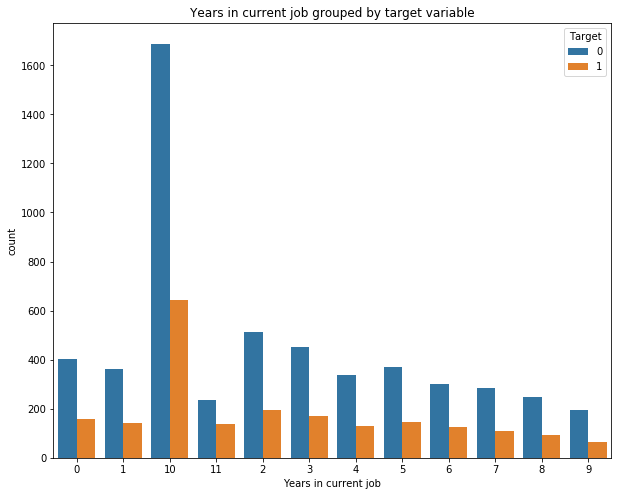

In [3091]:
show_size_matching(df, curr_name)

In [3092]:
show_chi2_p_vals(df, curr_name)

         0       1      10      11       2       3       4       5       6  \
0        1  0.9806   0.766  0.0052  0.7323  0.7526  0.9122   0.959  0.7653   
1   0.9806       1  0.7994   0.006  0.7596  0.7786  0.9329  0.9791  0.7537   
10   0.766  0.7994       1  0.0002  0.9006  0.9225   0.889  0.8237  0.5275   
11  0.0052   0.006  0.0002       1  0.0012  0.0017  0.0055  0.0054   0.019   
2   0.7323  0.7596  0.9006  0.0012       1  0.9859  0.8347  0.7797  0.5297   
3   0.7526  0.7786  0.9225  0.0017  0.9859       1  0.8515  0.7984  0.5506   
4   0.9122  0.9329   0.889  0.0055  0.8347  0.8515       1   0.953   0.697   
5    0.959  0.9791  0.8237  0.0054  0.7797  0.7984   0.953       1  0.7334   
6   0.7653  0.7537  0.5275   0.019  0.5297  0.5506   0.697  0.7334       1   
7   0.9429  0.9619  0.8646  0.0085  0.8157  0.8319  0.9743  0.9813  0.7326   
8   0.7203  0.7419  0.8542  0.0053  0.9358  0.9257  0.8034  0.7585  0.5478   
9   0.3468  0.3652  0.3883  0.0017  0.4786  0.4781   0.409  0.37

In [3093]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5662816.0, pvalue=0.3653328830002485)

In [3094]:
# show_confidence_int(df, curr_name)

In [3095]:
df.shape

(7500, 18)

<h2><span style="color:red">Years in current job</span> END<br>
    ________________________________

<h2 ><span style="color:red">Bankruptcies</span> BEGIN

In [3096]:
curr_name = 'Bankruptcies'

In [3097]:
df.loc[(df[curr_name].isna()) & (df[TARGET_NAME] == 1), ['Id', curr_name]].count()[0]

4

In [3098]:
df_test.loc[df_test[curr_name].isna(), curr_name].count()

0

In [3099]:
df[[curr_name, TARGET_NAME]].groupby([curr_name,TARGET_NAME]).size()

Bankruptcies  Credit Default
0.0           0                 4782
              1                 1878
1.0           0                  569
              1                  217
2.0           0                   20
              1                   11
3.0           0                    5
              1                    2
4.0           0                    1
              1                    1
dtype: int64

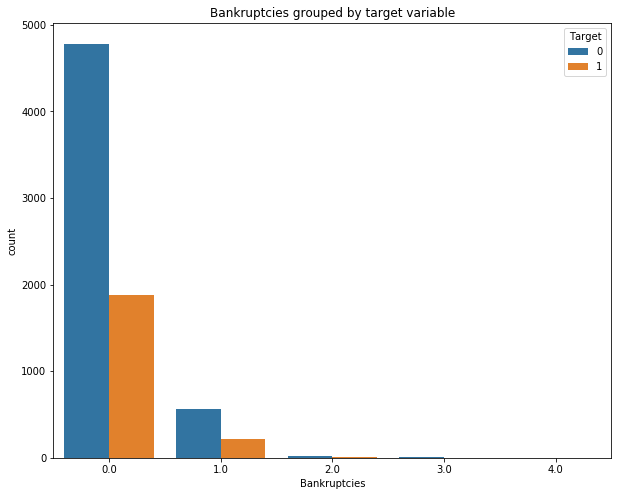

In [3100]:
show_size_matching(df, curr_name)

In [3101]:
df = mod_Bankruptcies(df)
df_test = mod_Bankruptcies(df_test)

In [3102]:
show_chi2_p_vals(df, curr_name)

        0       1       2
0       1   0.729  0.3641
1   0.729       1  0.9052
2  0.3641  0.9052       1


In [3103]:
drop_columns.append(curr_name)

In [3104]:
df.shape

(7500, 18)

<h2><span style="color:red">Bankruptcies</span> END<br>
________________________________

<h2 ><span style="color:red">Home Ownership </span> BEGIN

In [3105]:
curr_name = 'Home Ownership'

In [3106]:
df[curr_name].describe()

count              7500
unique                4
top       Home Mortgage
freq               3637
Name: Home Ownership, dtype: object

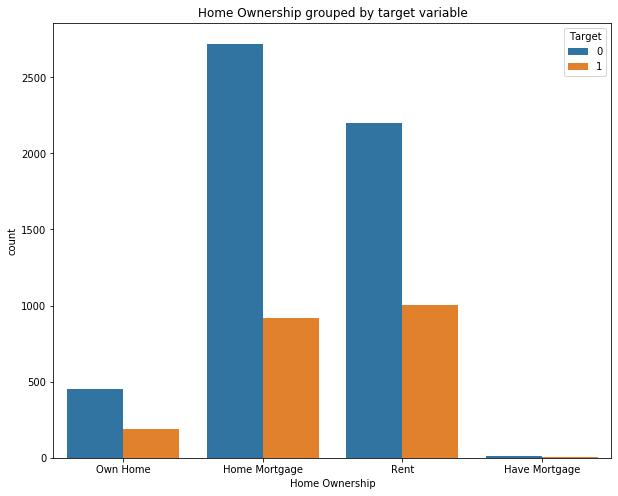

In [3107]:
show_size_matching(df, curr_name)

In [3108]:
show_chi2_p_vals(df, curr_name)

              Have Mortgage Home Mortgage Own Home    Rent
Have Mortgage             1        0.4972   0.3272  0.2749
Home Mortgage        0.4972             1   0.0163       0
Own Home             0.3272        0.0163        1  0.4139
Rent                 0.2749             0   0.4139       1


In [3109]:
df = mod_Home_Ownership(df)
df_test = mod_Home_Ownership(df_test)

In [3110]:
show_chi2_p_vals(df, curr_name)

        1       2       3
1       1  0.4139  0.0155
2  0.4139       1       0
3  0.0155       0       1


In [3111]:
df.shape

(7500, 18)

<h2><span style="color:red">Home Ownership</span> END<br>________________________________

<h2 ><span style="color:red">Tax Liens</span> BEGIN

In [3112]:
curr_name = 'Tax Liens'

In [3113]:
df[curr_name].unique()

array([0., 3., 1., 2., 4., 6., 5., 7.])

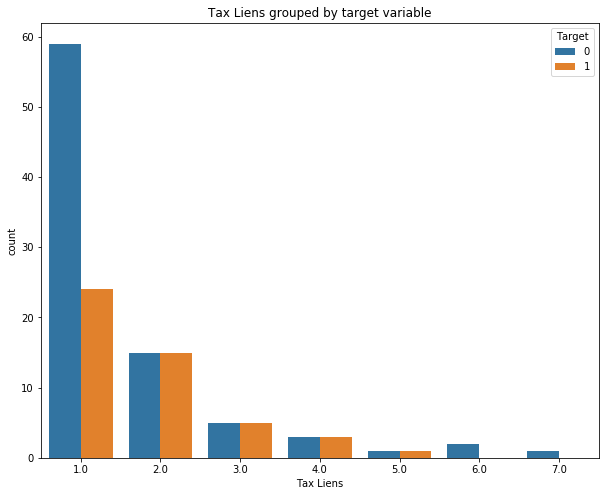

In [3114]:
show_size_matching(df.loc[df[curr_name] != 0] , curr_name)

In [3115]:
df = df.loc[df[curr_name] <=5]

In [3116]:
show_chi2_p_vals(df, curr_name)

        0.0     1.0     2.0     3.0     4.0     5.0
0.0       1  0.8589  0.0076  0.1224  0.2312  0.4893
1.0  0.8589       1  0.0374  0.1739   0.278  0.5179
2.0  0.0076  0.0374       1       1       1       1
3.0  0.1224  0.1739       1       1       1       1
4.0  0.2312   0.278       1       1       1       1
5.0  0.4893  0.5179       1       1       1       1


In [3117]:
df = mod_Tax_Liens(df)
df_test = mod_Tax_Liens(df_test)

In [3118]:
show_chi2_p_vals(df, curr_name)

        0       1
0       1  0.0008
1  0.0008       1


In [3119]:
df.shape

(7497, 18)

<h2><span style="color:red">Tax Liens </span> END<br>________________________________

<h2 ><span style="color:red">Term</span> BEGIN

In [3120]:
curr_name = 'Term'

In [3121]:
df_test[curr_name].value_counts()

Short Term    1861
Long Term      639
Name: Term, dtype: int64

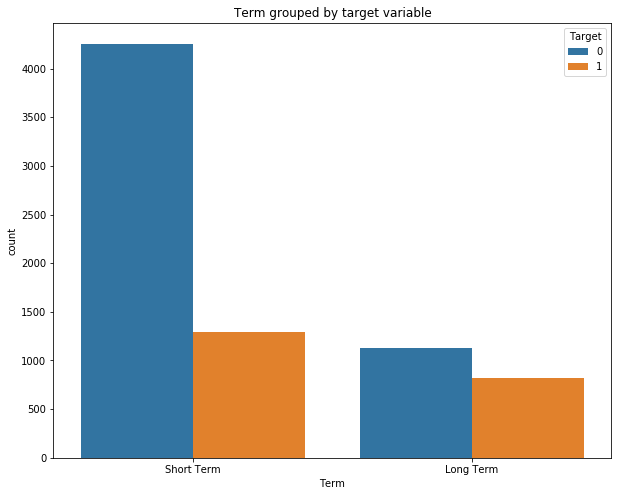

In [3122]:
show_size_matching(df, curr_name)

In [3123]:
df = mod_Term(df)
df_test = mod_Term(df_test)

In [3124]:
df.shape

(7497, 18)

<h2><span style="color:red">Term</span> END<br>________________________________

<h2 ><span style="color:red">Purpose</span> BEGIN

In [3125]:
curr_name = 'Purpose'

In [3126]:
df[curr_name].value_counts()

debt consolidation      5942
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             70
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

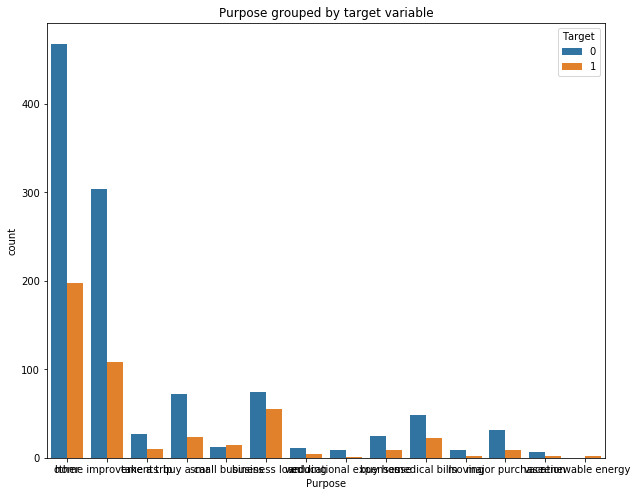

In [3127]:
show_size_matching(df.loc[~df[curr_name].isin(['debt consolidation'])], curr_name)

In [3128]:
df_test.loc[df_test[curr_name] == 'renewable energy', curr_name].count()

0

In [3129]:
df = df.loc[df[curr_name] != 'renewable energy']

In [3130]:
show_chi2_p_vals(df, curr_name)

                     business loan buy a car buy house debt consolidation  \
business loan                    1    0.0061     0.086             0.0002   
buy a car                   0.0061         1    0.8655             0.5384   
buy house                    0.086    0.8655         1             0.8594   
debt consolidation          0.0002    0.5384    0.8594                  1   
educational expenses        0.0427    0.2876    0.2746             0.2085   
home improvements           0.0004    0.8071    0.9739             0.4769   
major purchase              0.0218    0.7566    0.6916             0.4528   
medical bills               0.1211    0.3608    0.6041             0.5051   
moving                      0.1131    0.6175    0.5782             0.4753   
other                       0.0037    0.3508     0.694             0.3301   
small business               0.294    0.0048    0.0307             0.0032   
take a trip                 0.0864    0.8102    0.9578             0.9129   

In [3131]:
df = mod_Purpose(df)
df_test = mod_Purpose(df_test)

In [3132]:
show_chi2_p_vals(df, curr_name)

        0       1       2       3       4       5
0       1  0.3244  0.2006  0.0032  0.0002  0.5027
1  0.3244       1   0.091  0.0085  0.0037  0.7535
2  0.2006   0.091       1  0.0013  0.0001  0.2704
3  0.0032  0.0085  0.0013       1   0.294  0.0438
4  0.0002  0.0037  0.0001   0.294       1  0.1211
5  0.5027  0.7535  0.2704  0.0438  0.1211       1


In [3133]:
df.shape

(7495, 18)

<h2><span style="color:red">Purpose</span> END<br>________________________________

<h2 ><span style="color:red">Months since last delinquent</span> BEGIN

In [3134]:
curr_name = 'Months since last delinquent'

In [3135]:
df_test[curr_name].max()

82.0

In [3136]:
df.loc[(df[curr_name] > df_test[curr_name].max()) & (df[TARGET_NAME] == 0), curr_name].count()

4

In [3137]:
df = mod_Months_since_last_delinquent(df, df[curr_name].median(), df_test[curr_name].max())
df_test = mod_Months_since_last_delinquent(df_test, df[curr_name].median(), df_test[curr_name].max())

In [3138]:
df.loc[df[TARGET_NAME] == 1, curr_name].max()

82.0

In [3139]:
df = df.loc[df[curr_name] < 83]

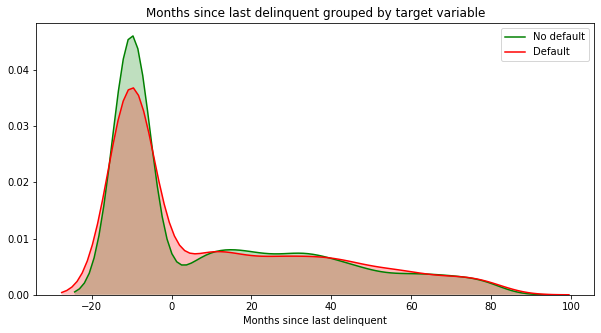

In [3140]:
show_plot_matching(df, curr_name)

In [3141]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5606448.0, pvalue=0.1611791506508266)

In [3142]:
drop_columns.append(curr_name)

In [3143]:
df.shape

(7495, 18)

<h2><span style="color:red">Months since last delinquent</span> END<br>________________________________

<h2 ><span style="color:red">Number of Credit Problems</span> BEGIN

In [3144]:
curr_name = 'Number of Credit Problems'

In [3145]:
df_test[curr_name].value_counts()

0.0     2177
1.0      280
2.0       29
3.0        7
5.0        4
15.0       1
4.0        1
7.0        1
Name: Number of Credit Problems, dtype: int64

In [3146]:
df = df.loc[df[curr_name] < 6]

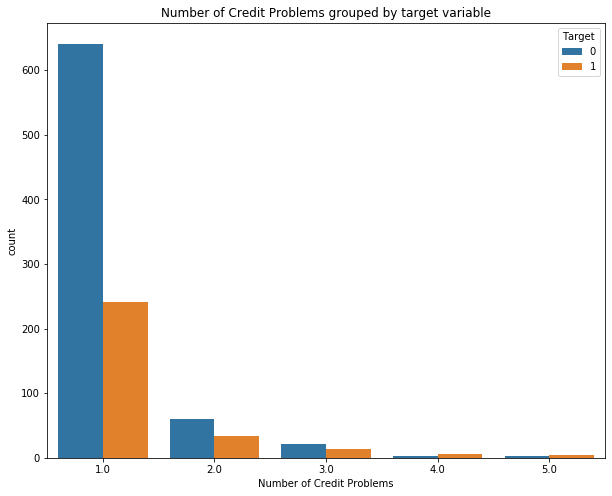

In [3147]:
show_size_matching(df.loc[df[curr_name] != 0], curr_name)

In [3148]:
show_chi2_p_vals(df, curr_name)

        0.0     1.0     2.0     3.0     4.0     5.0
0.0       1  0.6592  0.1127  0.1163    0.01  0.0867
1.0  0.6592       1  0.0959  0.1007  0.0087  0.0786
2.0  0.1127  0.0959       1  0.6366   0.066  0.2524
3.0  0.1163  0.1007  0.6366       1  0.1519  0.4028
4.0    0.01  0.0087   0.066  0.1519       1  0.6963
5.0  0.0867  0.0786  0.2524  0.4028  0.6963       1


In [3149]:
df = mod_Number_of_Credit_Problems(df)
df_test = mod_Number_of_Credit_Problems(df_test)

In [3150]:
show_chi2_p_vals(df, curr_name)

        0       3       4
0       1  0.0286  0.0021
3  0.0286       1  0.0468
4  0.0021  0.0468       1


In [3151]:
df.shape

(7493, 18)

<h2><span style="color:red">Number of Credit Problems</span> END<br>________________________________

<h2 ><span style="color:red">Years of Credit History</span> BEGIN

In [3152]:
curr_name = 'Years of Credit History'

In [3153]:
df_test[curr_name].max(), int(df[curr_name].quantile(0.99))

(53.4, 40)

In [3154]:
quantile_p = int(df[curr_name].quantile(0.99))
df = mod_remove_tail(df, curr_name, quantile_p )
df_test = mod_remove_tail(df_test, curr_name, quantile_p)

In [3155]:
df[curr_name].max()

40.0

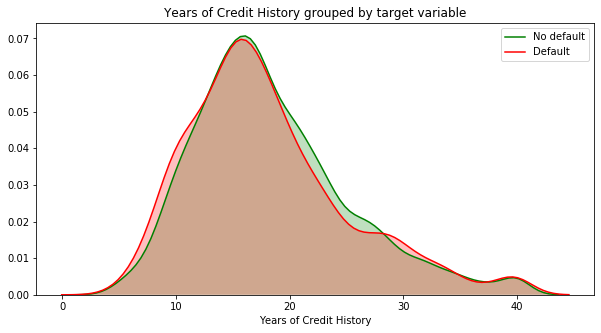

In [3156]:
show_plot_matching(df, curr_name)

In [3157]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5447978.0, pvalue=0.0028645486538197854)

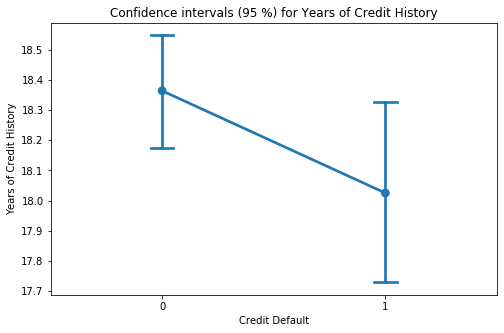

In [3158]:
show_confidence_int(df, curr_name)

In [3159]:
df.shape

(7493, 18)

<h2><span style="color:red">Years of Credit History</span> END<br>________________________________

<h2 ><span style="color:red">Current Loan Amount</span> BEGIN

In [3160]:
curr_name = 'Current Loan Amount'

In [3161]:
df.loc[df[curr_name] == 99999999.0, curr_name].count(), df_test.loc[df_test[curr_name] == 99999999.0, curr_name].count()

(869, 297)

In [3162]:
quantile_p = int(df[curr_name].quantile(0.95))
median = df.loc[df[curr_name] < 900000, curr_name].median() 
df = mod_Current_Loan_Amount(df, median, quantile_p)
df_test = mod_Current_Loan_Amount(df_test, median, quantile_p)

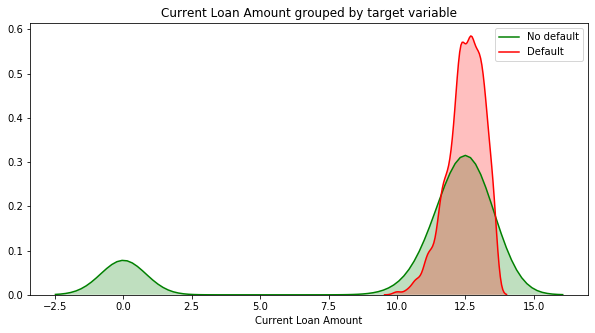

In [3163]:
show_plot_matching(df, curr_name)

In [3164]:
df.loc[df[TARGET_NAME] == 1, curr_name].min()

9.974551610967133

In [3165]:
# df = df.loc[df[curr_name] >= 10]

In [3166]:
df.shape

(7493, 18)

In [3167]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=4361447.0, pvalue=1.1355355574409653e-55)

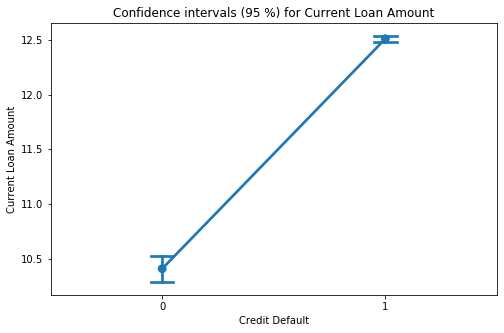

In [3168]:
show_confidence_int(df, curr_name)

In [3169]:
df.shape

(7493, 18)

<h2><span style="color:red">Current Loan Amount</span> END<br>________________________________

<h2 ><span style="color:red">Monthly Debt</span> BEGIN

In [3170]:
curr_name = 'Monthly Debt'

In [3171]:
df[curr_name].max(), df_test[curr_name].max(), int(df[curr_name].quantile(1))

(136679.0, 93555.0, 136679)

In [3172]:
df.loc[(df[curr_name] > df_test[curr_name].max()) & (df[TARGET_NAME] == 1), curr_name].count()

2

In [3173]:
df = df.loc[df[curr_name] <= df_test[curr_name].max()]

In [3174]:
quantile_p = df_test[curr_name].max()
df = mod_remove_tail(df, curr_name, quantile_p)
df_test = mod_remove_tail(df_test, curr_name, quantile_p)

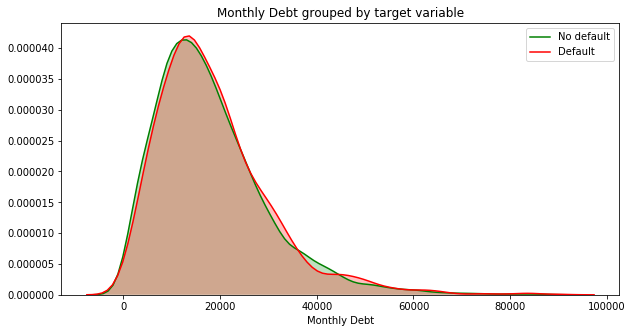

In [3175]:
show_plot_matching(df, curr_name)

In [3176]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5504867.0, pvalue=0.025498089169700484)

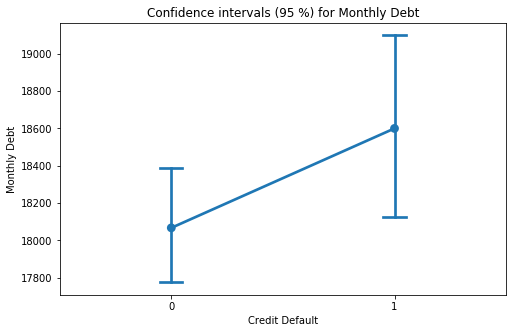

In [3177]:
show_confidence_int(df, curr_name)

In [3178]:
df.shape

(7485, 18)

<h2><span style="color:red">Monthly Debt</span> END<br>________________________________

<h2 ><span style="color:red">Current Credit Balance</span> BEGIN

In [3179]:
curr_name = 'Current Credit Balance'

In [3180]:
df[curr_name].max(), df_test[curr_name].max(), int(df[curr_name].quantile(0.99))

(6506797.0, 6030087.0, 1446194)

In [3181]:
quantile_p = 6000000
df = mod_Current_Credit_Balance(df,  quantile_p)
df_test = mod_Current_Credit_Balance(df_test, quantile_p)

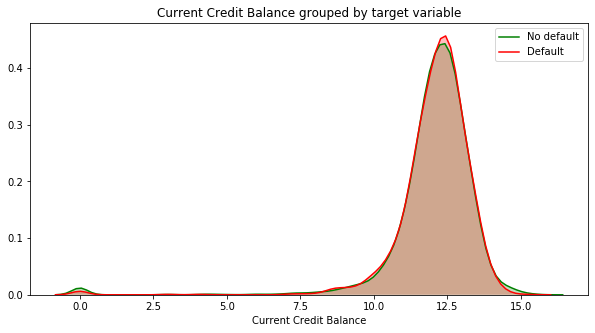

In [3182]:
show_plot_matching(df, curr_name)

In [3183]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5668815.0, pvalue=0.49916275545058497)

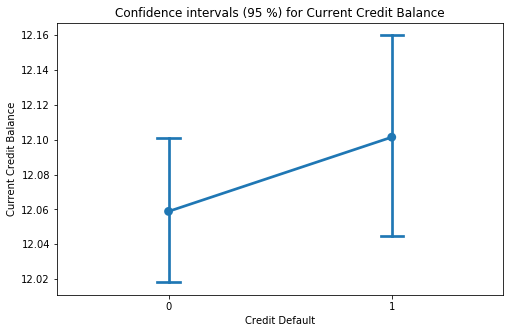

In [3184]:
show_confidence_int(df, curr_name)

In [3185]:
drop_columns.append(curr_name)

In [3186]:
df.shape

(7485, 18)

<h2><span style="color:red">Current Credit Balance</span> END<br>________________________________

<h2 ><span style="color:red">Maximum Open Credit</span> BEGIN

In [3187]:
curr_name = 'Maximum Open Credit'

In [3188]:
df[curr_name].max(), df_test[curr_name].max(), int(df[curr_name].quantile(0.99))

(1304726170.0, 54484386.0, 3487804)

In [3189]:
df.loc[(df[curr_name] == 0) & (df[TARGET_NAME] == 1), curr_name].count()

10

In [3190]:
# df = df.loc[df[curr_name] != 0]

In [3191]:
quantile_p = df_test[curr_name].max()
df = mod_Maximum_Open_Credit(df, quantile_p)
df_test = mod_Maximum_Open_Credit(df_test, quantile_p)

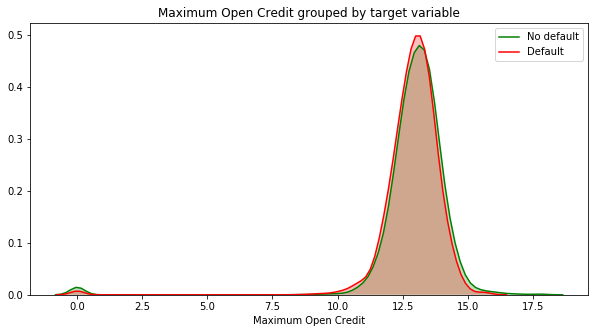

In [3192]:
show_plot_matching(df, curr_name)

In [3193]:
df.loc[df[TARGET_NAME] == 1, curr_name].max()

15.708525980648124

In [3194]:
df =  df.loc[df[curr_name] < 16]

In [3195]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5213520.0, pvalue=1.5054683653488653e-07)

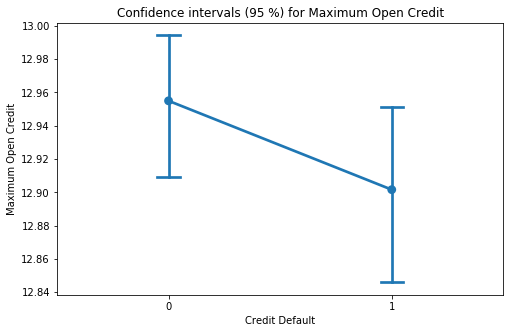

In [3196]:
show_confidence_int(df, curr_name)

In [3197]:
df.shape

(7460, 18)

<h2><span style="color:red">Maximum Open Credit</span> END<br>________________________________

<h2 ><span style="color:red">Number of Open Accounts</span> BEGIN

In [3198]:
curr_name = 'Number of Open Accounts'

In [3199]:
df[curr_name].max(), df_test[curr_name].max(), int(df[curr_name].quantile(0.99))

(43.0, 48.0, 26)

In [3200]:
df.loc[(df[curr_name] == 0) & (df[TARGET_NAME] == 1), curr_name].count()

0

In [3201]:
df = df.loc[df[curr_name] != 0]

In [3202]:
quantile_p = 43
df = mod_remove_tail(df, curr_name, quantile_p)
df_test = mod_remove_tail(df_test, curr_name, quantile_p)

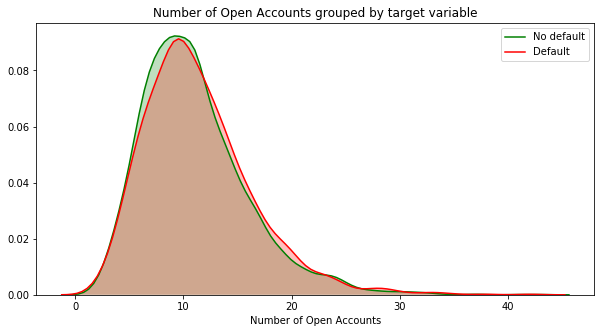

In [3203]:
show_plot_matching(df, curr_name)

In [3204]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5410429.0, pvalue=0.0027261480511604668)

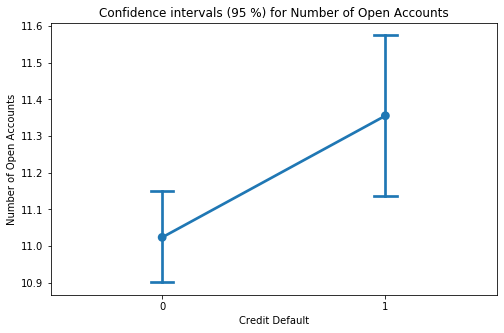

In [3205]:
show_confidence_int(df, curr_name)

In [3206]:
df.shape

(7460, 18)

<h2><span style="color:red">Number of Open Accounts</span> END<br>________________________________

<h2 ><span style="color:red">Credit Score</span> BEGIN

In [3207]:
curr_name = 'Credit Score'

In [3208]:
df.loc[df[curr_name].isna(), TARGET_NAME].value_counts()

0    1024
1     526
Name: Credit Default, dtype: int64

In [3209]:
median = -10
df = mod_Credit_Score(df, median)
df_test = mod_Credit_Score(df_test, median)

In [3210]:
df[curr_name].max(), df_test[curr_name].max(), int(df[curr_name].quantile(0.99))

(7510.0, 7480.0, 7370)

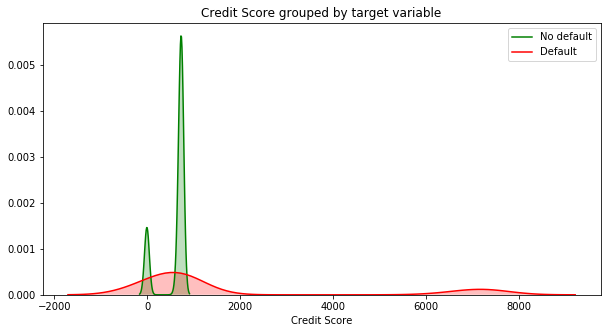

In [3211]:
show_plot_matching(df, curr_name)

In [3212]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=5482959.5, pvalue=0.02775281474072071)

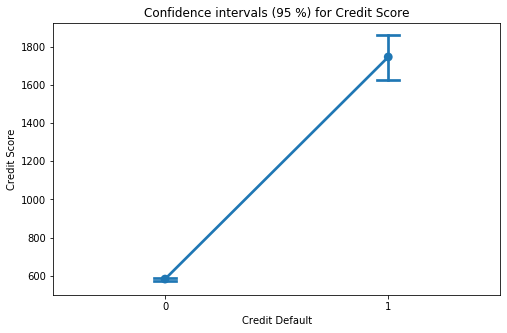

In [3213]:
show_confidence_int(df, curr_name)

In [3214]:
df.shape

(7460, 18)

<h2><span style="color:red">Credit Score</span> END<br>________________________________

<h2 ><span style="color:red">Annual Income</span> BEGIN

In [3215]:
curr_name = 'Annual Income'

In [3216]:
df.loc[df[curr_name].isna(), TARGET_NAME].value_counts()

0    1024
1     526
Name: Credit Default, dtype: int64

In [3217]:
df[curr_name].max(), df_test[curr_name].max(), int(df[curr_name].quantile(0.99))

(10149344.0, 14975610.0, 4378224)

In [3218]:
df[curr_name].min(), df_test[curr_name].min(), int(df[curr_name].quantile(0.01))

(164597.0, 106533.0, 326971)

In [3219]:
median = -10
p = df_test[curr_name].max()
df = mod_Annual_Income(df, median, p)
df_test = mod_Annual_Income(df_test, median, p)

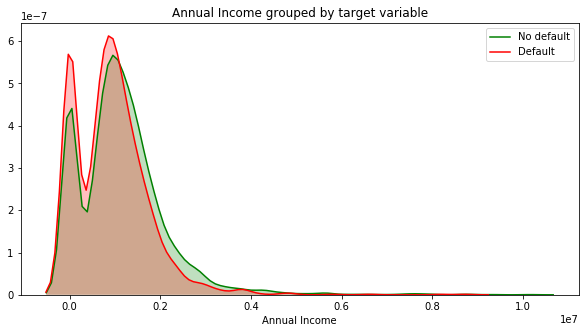

In [3220]:
show_plot_matching(df, curr_name)

In [3221]:
show_mannwhitneyu(df, curr_name)

MannwhitneyuResult(statistic=4825423.5, pvalue=5.631696713148737e-23)

In [3222]:
df.shape

(7460, 18)

<h2><span style="color:red">Annual Income</span> END<br>________________________________

<h2 ><span style="color:red">NEW NAMES</span> BEGIN

In [3223]:
new_names = {new_Credit_Score_bin:{}, 
             new_Months_since_last_delinquent_dummy: {},
             new_Bankruptcies_bin:{},
             new_Bankruptcies_bin2: {},
            }

# for new_col, params in new_names.items():
#     df = new_col(df, **params)
#     df_test = new_col(df_test, **params)

<h2><span style="color:red">NEW NAMES</span> END<br>________________________________

***Выделим бинарные переменные***

In [3224]:
binary_columns = [c for c in df.columns if set(df[c].unique()) == set([0, 1])]
binary_columns.remove(TARGET_NAME)
binary_columns

['Tax Liens', 'Term']

In [3225]:
df[binary_columns] = df[binary_columns].astype('uint8')
df_test[binary_columns] = df_test[binary_columns].astype('uint8')

df[binary_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7460 entries, 0 to 7499
Data columns (total 2 columns):
Tax Liens    7460 non-null uint8
Term         7460 non-null uint8
dtypes: uint8(2)
memory usage: 392.9 KB


***Выделим дамми переменные***

In [3226]:
nonbinary_columns = [c for c in df.columns if df[c].dtypes == 'object']
nonbinary_columns

['Home Ownership', 'Years in current job', 'Purpose']

***Рассмотрим числовые переменные***

In [3227]:
numerical_columns = list(set(df.columns) - set(binary_columns) - set(nonbinary_columns) - set([TARGET_NAME, 'Id']))
df[numerical_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7460 entries, 0 to 7499
Data columns (total 11 columns):
Number of Open Accounts         7460 non-null float64
Bankruptcies                    7460 non-null int8
Credit Score                    7460 non-null float64
Number of Credit Problems       7460 non-null int64
Months since last delinquent    7460 non-null float64
Maximum Open Credit             7460 non-null float64
Monthly Debt                    7460 non-null float64
Current Loan Amount             7460 non-null float64
Annual Income                   7460 non-null float64
Current Credit Balance          7460 non-null float64
Years of Credit History         7460 non-null float64
dtypes: float64(9), int64(1), int8(1)
memory usage: 968.4 KB


***ПОЯВЛЕНИЕ ФИЛЬНАЛЬНОГО DF***

In [3228]:
nonbinary_dummy_data = pd.get_dummies(df[nonbinary_columns])
binary_data = df[binary_columns]
numerical_data = df[numerical_columns]

df_final = pd.concat([numerical_data, binary_data, nonbinary_dummy_data, df[TARGET_NAME]], axis=1).copy()

In [3229]:
nonbinary_dummy_data_test = pd.get_dummies(df_test[nonbinary_columns])
binary_data_test = df_test[binary_columns]
numerical_data_test = df_test[numerical_columns]

df_final_test = pd.concat([numerical_data_test, binary_data_test, nonbinary_dummy_data_test], axis=1).copy()

In [3230]:
# df_final = df_final.drop(columns=drop_columns)
# df_final_test = df_final_test.drop(columns=drop_columns)
# numerical_columns = list(set(numerical_columns) - set(drop_columns))

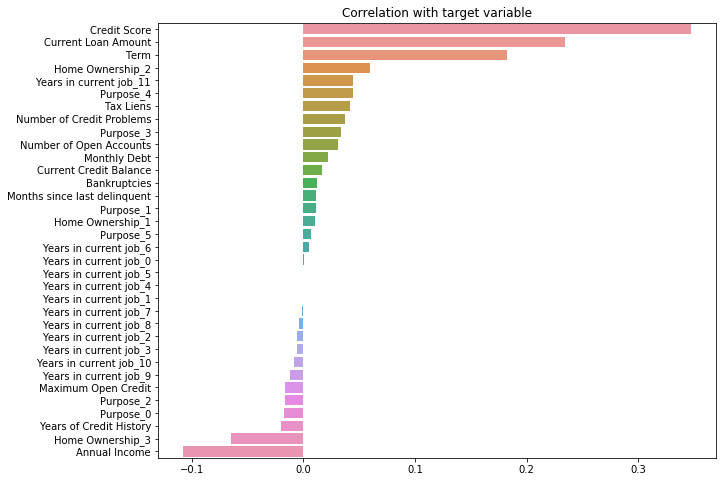

In [3231]:
BASE_FEATURE_NAMES = df_final.columns.tolist()
corr_with_target = df_final[BASE_FEATURE_NAMES].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values[:], y=corr_with_target.index[:])

plt.title('Correlation with target variable')
plt.show()

***Нормализация данных***

In [3232]:
scaler_metod = MinMaxScaler

df_final_scaled = mod_scaler(df_final, numerical_columns, scaler_metod)
df_final_test_scaled = mod_scaler(df_final_test, numerical_columns, scaler_metod)

In [3233]:
scaled = True
X = df_final_scaled.drop(columns=[TARGET_NAME]) if scaled else df_final.drop(columns=[TARGET_NAME])
y = df_final_scaled[TARGET_NAME] if scaled else df_final[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21, stratify=y)

***Отбор признаков***

In [3234]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, 1)
    
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]
df_balanced[TARGET_NAME].value_counts()

0    3746
1    2952
Name: Credit Default, dtype: int64

In [3235]:
ALL_NAMES = True

if not ALL_NAMES:
    MODEL = lgbm.LGBMClassifier

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=21)
    model = MODEL(random_state=21)

    rf = RFECV(model, cv=cv,  n_jobs=-1, scoring='f1')
    rf.fit(X_train, y_train)

In [3236]:
FEATURE_NAMES_SELECTED = df_final.drop(columns=[TARGET_NAME]).columns if ALL_NAMES else list(X_train.loc[:, rf.support_].columns)
FEATURE_NAMES_SELECTED

Index(['Number of Open Accounts', 'Bankruptcies', 'Credit Score',
       'Number of Credit Problems', 'Months since last delinquent',
       'Maximum Open Credit', 'Monthly Debt', 'Current Loan Amount',
       'Annual Income', 'Current Credit Balance', 'Years of Credit History',
       'Tax Liens', 'Term', 'Home Ownership_1', 'Home Ownership_2',
       'Home Ownership_3', 'Years in current job_0', 'Years in current job_1',
       'Years in current job_10', 'Years in current job_11',
       'Years in current job_2', 'Years in current job_3',
       'Years in current job_4', 'Years in current job_5',
       'Years in current job_6', 'Years in current job_7',
       'Years in current job_8', 'Years in current job_9', 'Purpose_0',
       'Purpose_1', 'Purpose_2', 'Purpose_3', 'Purpose_4', 'Purpose_5'],
      dtype='object')

In [3237]:
gred_params = {
    "learning_rate": [0.1],
    "max_depth": [ 2, 3],
    "n_estimators": range(250, 551, 50)
}

MODEL = lgbm.LGBMClassifier

def gred_model(modelClassifier, gred_params, X_train, y_train, X_test, y_test):
    max_f1 = result = 0
    max_params = params = {}
    iter_len = reduce(lambda x, y: x*y, [len(p) for p in gred_params.values()])
    with tqdm(product(*gred_params.values()), 
              total=iter_len,  
              bar_format='{l_bar} {bar} |{n_fmt}/{total_fmt}|{remaining}| {postfix}') as gred_dicts:
        for i in gred_dicts:
            params = dict(zip(gred_params.keys(), i))
            model = modelClassifier(**params, random_state=21, silent=True)
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)
            result = f1_score(y_test, y_test_pred)
            if result > max_f1:
                max_f1 = result
                max_params = params
            gred_dicts.set_postfix_str(s=f'| Max_f1={round(max_f1, 5)} | last_f1={round(result, 5)} | best={max_params} | \
                                        current={params}', refresh=True)
    return max_f1, max_params

gred_model(MODEL, gred_params, X_train[FEATURE_NAMES_SELECTED], y_train, X_test[FEATURE_NAMES_SELECTED], y_test)

100%| ██████████ |14/14|00:00| , | Max_f1=0.53312 | last_f1=0.52 | best={'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 250} |                                         current={'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 550}   


(0.5331179321486268,
 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 250})

In [3243]:
params = {
 'n_estimators': 250,
 'max_depth': 2,
 'learning_rate': 0.1,
 }

model = MODEL(**params, silent=True, random_state=21)
model.fit(X_train[FEATURE_NAMES_SELECTED], y_train)

y_train_pred = model.predict(X_train[FEATURE_NAMES_SELECTED])
y_test_pred = model.predict(X_test[FEATURE_NAMES_SELECTED])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
print(f1_score(y_test, y_test_pred))

TRAIN
              precision    recall  f1-score   support

           0       0.73      0.85      0.78      3746
           1       0.76      0.60      0.67      2952

    accuracy                           0.74      6698
   macro avg       0.74      0.72      0.73      6698
weighted avg       0.74      0.74      0.73      6698

TEST
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1605
           1       0.55      0.52      0.53       633

    accuracy                           0.74      2238
   macro avg       0.68      0.67      0.68      2238
weighted avg       0.74      0.74      0.74      2238

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1330  275
1                303  330
0.5331179321486268


In [5173]:
param_distributions = {
    'n_estimators': range(100, 2101, 50),
    'max_depth': range(1, 9),
    'learning_rate': [0.1],
    
    'subsample': np.linspace(0.05, 0.95, 19),
    'colsample_bytree': np.linspace(0.6, 0.95, 19),
    
    'reg_alpha': np.linspace(0.05, 0.95, 19),
    'reg_lambda': np.linspace(0.05, 0.95, 19)
}

n = 5000

rs = RandomizedSearchCV(model, param_distributions=param_distributions, 
                        scoring='neg_log_loss', n_iter=n, cv=skf, n_jobs=4, verbose=True, random_state=21)
# rs.fit(X_train[FEATURE_NAMES_SELECTED], y_train)

Fitting 3 folds for each of 5000 candidates, totalling 15000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   48.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  9.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 13.2min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 15.8min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 19.0min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 22.5min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 26.4min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 30.6min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 35.1min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 40.0min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 45.4mi

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=2,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=1600, n_jobs=-1,
                                            num_leave...
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'reg_lambda': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 

In [5174]:
rs.best_score_

-0.5208421283427522

In [5222]:
MODEL_PROBA = rs.best_estimator_

In [5179]:
best_params = {'subsample': 0.95,
 'reg_lambda': 0.55,
 'reg_alpha': 0.05,
 'n_estimators': 600,
 'max_depth': 1,
 'learning_rate': 0.1,
 'colsample_bytree': 0.814}

In [1036]:
def test_best_proba(y, y_proba, step):
    f1_best = p_best = p = 0
    while p < 1 + step/2:
        f1 = f1_score(np.array(y_proba >= p).astype('int'), y)
        if  f1 >= f1_best:
            f1_best, p_best = f1, p
        p += step
    return p_best, f1_best            

In [3051]:
y_train_proba = model.predict_proba(X_train[FEATURE_NAMES_SELECTED])[:, 1]
p, f1 = test_best_proba(y_train, y_train_proba, 0.001)
print(p, f1)

0.3900000000000003 0.7249962736622447


/home/kach/projects/gb-ds/ds_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [3052]:
y_train_proba = model.predict_proba(X_train[FEATURE_NAMES_SELECTED])[:, 1]
y_test_proba =  model.predict_proba(X_test[FEATURE_NAMES_SELECTED])[:, 1]

eps = 0
y_train_proba_bool = np.array(y_train_proba >= p-eps).astype('int')
y_test_proba_bool  = np.array(y_test_proba  >= p-eps).astype('int')

get_classification_report(y_train, y_train_proba_bool, y_test, y_test_proba_bool)

TRAIN
              precision    recall  f1-score   support

           0       0.82      0.65      0.72      3746
           1       0.65      0.82      0.72      2952

    accuracy                           0.72      6698
   macro avg       0.74      0.74      0.72      6698
weighted avg       0.75      0.72      0.72      6698

TEST
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      1605
           1       0.44      0.75      0.55       633

    accuracy                           0.66      2238
   macro avg       0.65      0.68      0.64      2238
weighted avg       0.74      0.66      0.67      2238

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               995  610
1               161  472


In [3053]:
y_test_final_proba = model.predict_proba(df_final_test_scaled[FEATURE_NAMES_SELECTED])[:, 1]

In [3054]:
y_pred = np.array(y_test_final_proba >= p-eps).astype('int')

In [3056]:
model.fit(X[FEATURE_NAMES_SELECTED], y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=2,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=250, n_jobs=-1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [3060]:
y_pred = model.predict(df_final_test_scaled[FEATURE_NAMES_SELECTED])

In [3061]:
sum(y_pred), sum(y), sum(y_train_pred)

(1507, 2109, 2327)

In [1110]:
len(y_pred)

2500

In [1104]:
df_test[TARGET_NAME] = y_pred

In [1105]:
df_test[['Id', TARGET_NAME]].astype('int').to_csv(PRED_OUTPUT_FILE, index=None)